# Research on metrics for spaced repetition algorithms

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/spaced-repetition-algorithm-metric/blob/main/metrics_research.ipynb)

## 1. Generate sample data

In [1]:
import random
from scipy import stats

random.seed(42)

a = 4.5
b = 1.5
sample_size = 100_000

number = stats.beta.rvs(a, b, size=sample_size, random_state=42)

p = [x for x in number]
y = [1 if random.random() < x else 0 for x in p]

## 2. Define metrics

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return {
        "AUC": auc,
        "AP": ap,
        "Log loss": logloss,
        "RMSE": rmse,
        "MAE": mae
    }

## 3. Calculate metrics

In [3]:
import pandas as pd

table = dict()
table["Perfect"] = evaluate(y, p)
table["Overestimate"] = evaluate(y, list(map(lambda x: x + 0.05, p)))
table["Underestimate"] = evaluate(y, list(map(lambda x: x - 0.05, p)))
table["Random"] = evaluate(y, [random.random() for _ in range(len(y))])
table["Average"] = evaluate(y, [sum(y)/len(y)] * len(y))
df = pd.DataFrame.from_dict(table, orient='index')
df

,AUC,AP,Log loss,RMSE,MAE
Perfect,0.740336,0.890821,0.490658,0.401879,0.322161
Overestimate,0.740336,0.890821,0.573413,0.405089,0.300362
Underestimate,0.740336,0.890821,0.498994,0.404867,0.347113
Random,0.501088,0.750967,0.996777,0.576875,0.499272
Average,0.500000,0.749520,0.562862,0.433289,0.375480


## 4. Analyze metrics

When the prediction is perfect, a good metric should indicate that the prediction is perfect.

According to the results of above section, Log loss and RMSE are good metrics. Because they achieve the minimum value when the prediction is perfect.

MAE is not a good metric. Because it indicates the overestimation is better than the perfect prediction.

AUC and AP are not good metrics. Because they don't distinguish the perfect prediction from the overestimation and underestimation.

## 5. What about calibration graphs?

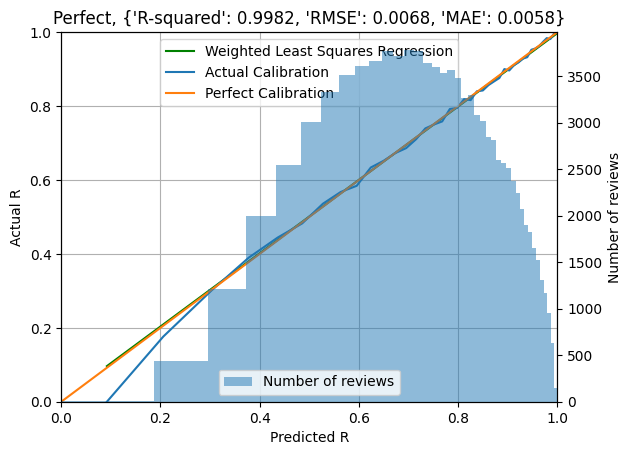

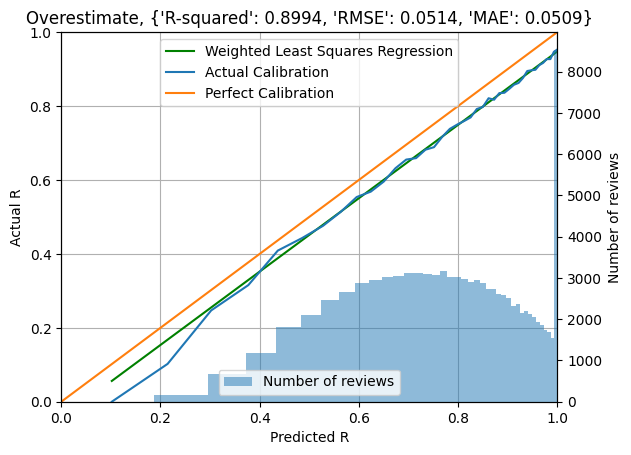

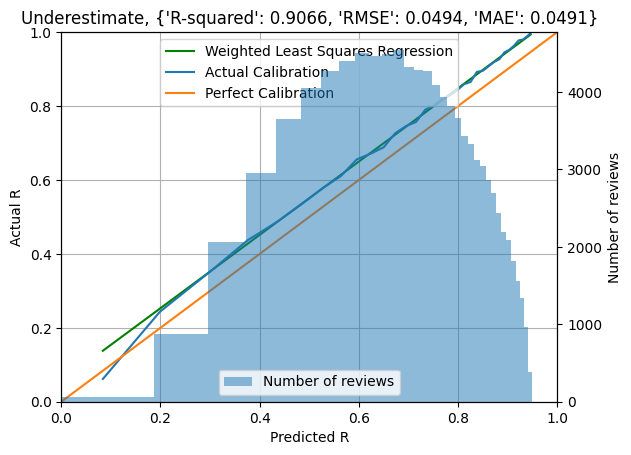

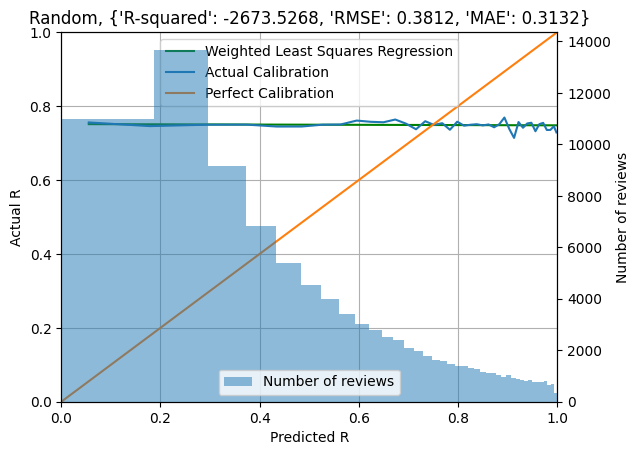

/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


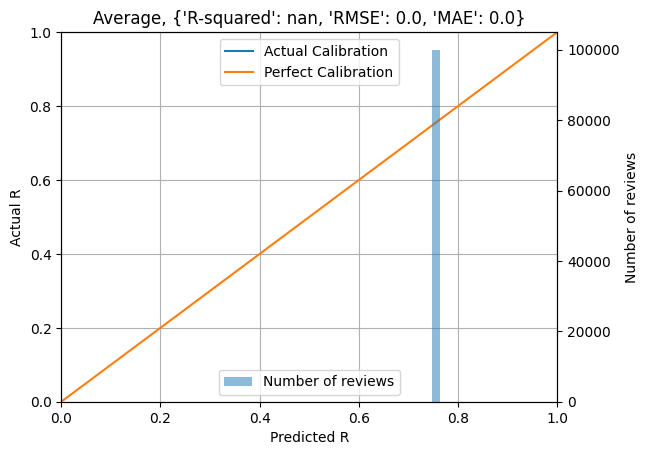

In [4]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)

    def get_bin(x, bins=bins):
        return int(np.exp(np.log(bins) * x).round() - 1)
    
    for p, r in zip(predictions, real):
        bin = min(get_bin(p), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    
    np.seterr(invalid='ignore')
    mask = counts > 0
    prediction_means = prediction / counts
    correct_means = correct / counts
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": counts,
            "bin_prediction_means": prediction_means,
            "bin_correct_means": correct_means,
        }
    }

def plot_brier(predictions, real, bins=20, title=None):
    brier = load_brier(predictions, real, bins=bins)
    bin_prediction_means = brier['detail']['bin_prediction_means']
    bin_correct_means = brier['detail']['bin_correct_means']
    bin_counts = brier['detail']['bin_counts']
    mask = bin_counts > 0
    r2 = r2_score(bin_correct_means[mask], bin_prediction_means[mask], sample_weight=bin_counts[mask])
    rmse = mean_squared_error(bin_correct_means[mask], bin_prediction_means[mask], sample_weight=bin_counts[mask], squared=False)
    mae = mean_absolute_error(bin_correct_means[mask], bin_prediction_means[mask], sample_weight=bin_counts[mask])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(True)
    try:
        fit_wls = sm.WLS(bin_correct_means[mask], sm.add_constant(bin_prediction_means[mask]), weights=bin_counts[mask]).fit()
        y_regression = [fit_wls.params[0] + fit_wls.params[1]*x for x in bin_prediction_means[mask]]
        plt.plot(bin_prediction_means[mask], y_regression, label='Weighted Least Squares Regression', color="green")
    except:
        pass
    plt.plot(bin_prediction_means, bin_correct_means, label='Actual Calibration', color="#1f77b4")
    plt.plot((0, 1), (0, 1), label='Perfect Calibration', color="#ff7f0e")
    bin_count = brier['detail']['bin_count']
    counts = np.array(bin_counts)
    bins = np.log((np.arange(bin_count)) + 1) / np.log(bin_count + 1)
    widths = np.diff(bins)
    widths = np.append(widths, 1 - bins[-1])
    plt.legend(loc='upper center')
    plt.xlabel('Predicted R')
    plt.ylabel('Actual R')
    ax2 = plt.twinx()
    ax2.set_ylabel('Number of reviews')
    ax2.bar(bins, counts, width=widths, ec='k', linewidth=0, alpha=0.5, label='Number of reviews', align='edge')
    ax2.legend(loc='lower center')
    metrics = {
        "R-squared": round(r2, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
    }
    if title:
        plt.title(f"{title}, {metrics}")
    plt.show()

n_bins = 40

plot_brier(p, y, bins=n_bins, title="Perfect")
plot_brier(list(map(lambda x: x + 0.05, p)), y, bins=n_bins, title="Overestimate")
plot_brier(list(map(lambda x: x - 0.05, p)), y, bins=n_bins, title="Underestimate")
plot_brier([random.random() for _ in range(len(y))], y, bins=n_bins, title="Random")
plot_brier([sum(y)/len(y)] * len(y), y, bins=n_bins, title="Average")

According to the above graphs, average prediction cheats the calibration graph metric easily.